In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, interpolate
import casadi as ca

In [40]:
%matplotlib inline

## Yanking from
https://github.com/CardiacModelling/FourWaysOfFitting/blob/main/model-and-protocols/beattie-2017-ikr-hh.mmt

In [3]:
volt_ts, volts = np.genfromtxt("./protocol-staircaseramp.csv", skip_header=1, dtype=float, delimiter=',').T

In [21]:
volt_fn = interpolate.interp1d(volt_ts, volts, kind='previous')
volt_ca = ca.interpolant('volts', 'linear', [volt_ts], volts)

In [32]:
def V_np(t):
#     return -80 + ca.floor(t/1000) * 20 + ca.mod(ca.floor(t/500), 2) * -10
    return volt_fn(t/1000)

In [33]:
def V_ca(t):
    return volt_ca(t/1000)

In [35]:
V = V_np

In [24]:
# V = -80 #mV
EK = -88.4 #mV

def ion_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*ca.exp(p[1]*V(t))
    k2 = p[2]*ca.exp(-p[3]*V(t))
    k3 = p[4]*ca.exp(p[5]*V(t))
    k4 = p[6]*ca.exp(-p[7]*V(t))
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]

In [25]:
def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V(t) - EK)

In [26]:
y0 = [ # a, r
    0, 1]

p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

In [27]:
tlim = [0, 15_000]
ts = np.linspace(*tlim, tlim[-1])

In [28]:
ar_sol = integrate.solve_ivp(ion_model, tlim, y0, args=[p_true], dense_output=True)

ValueError: could not broadcast input array from shape (2,1,1) into shape (2,)

In [ ]:
plt.figure()
plt.plot(ts, ar_sol.sol(ts).T, label=['a', 'r'])
plt.yscale('symlog', linthresh=1e-3)
# for yi in ar_sol.t:
#     plt.axvline(yi, color='k', lw=0.1)
plt.legend()

In [12]:
ar_sol_a, ar_sol_r = ar_sol.sol(ts)

In [13]:
ar_O = ar_sol_a*ar_sol_r
ar_I = ar_sol_a*(1-ar_sol_r)
ar_C = (1-ar_sol_a)*ar_sol_r
ar_IC = (1-ar_sol_a)*(1-ar_sol_r)
ar_stack = np.vstack([ar_O, ar_I, ar_C, ar_IC])


<IPython.core.display.Javascript object>


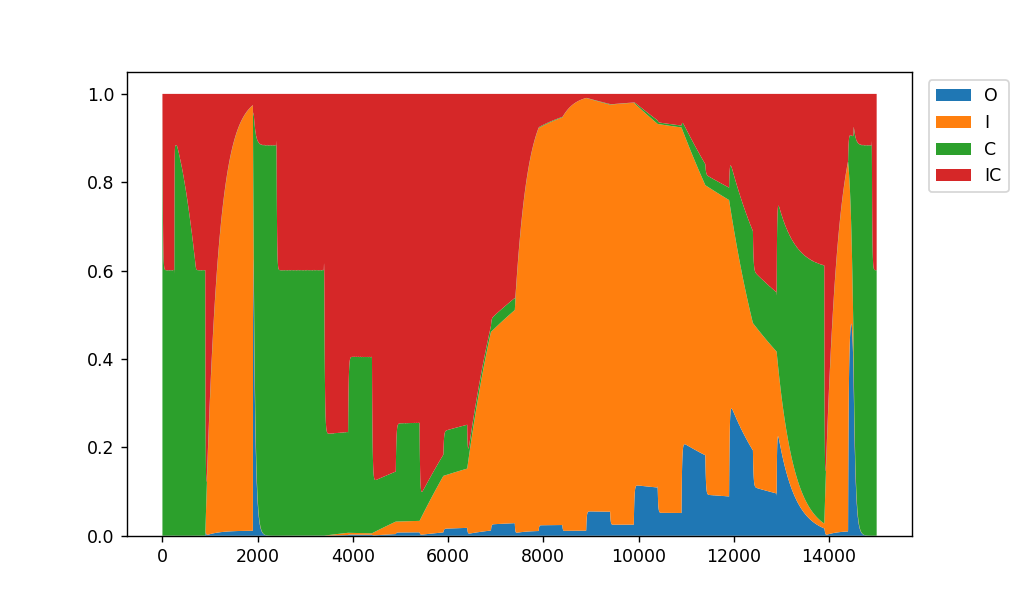

In [14]:
plt.figure()
plt.stackplot(ts, ar_stack, labels=['O', 'I', 'C', 'IC'])
plt.legend(bbox_to_anchor=[1.01, 1], loc='upper left')

<IPython.core.display.Javascript object>


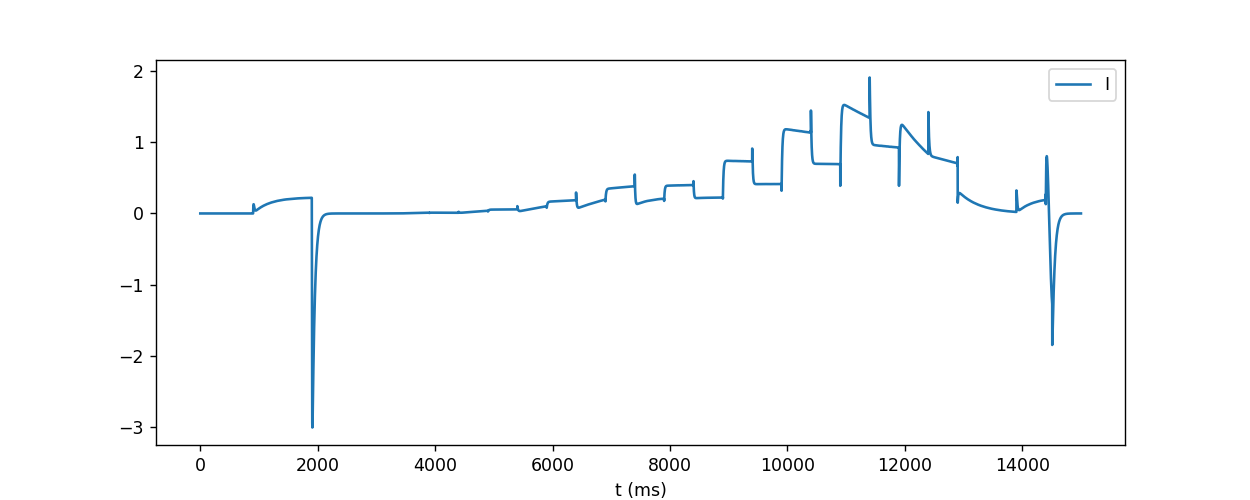

Text(0.5, 0, 't (ms)')

In [15]:
plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

<IPython.core.display.Javascript object>


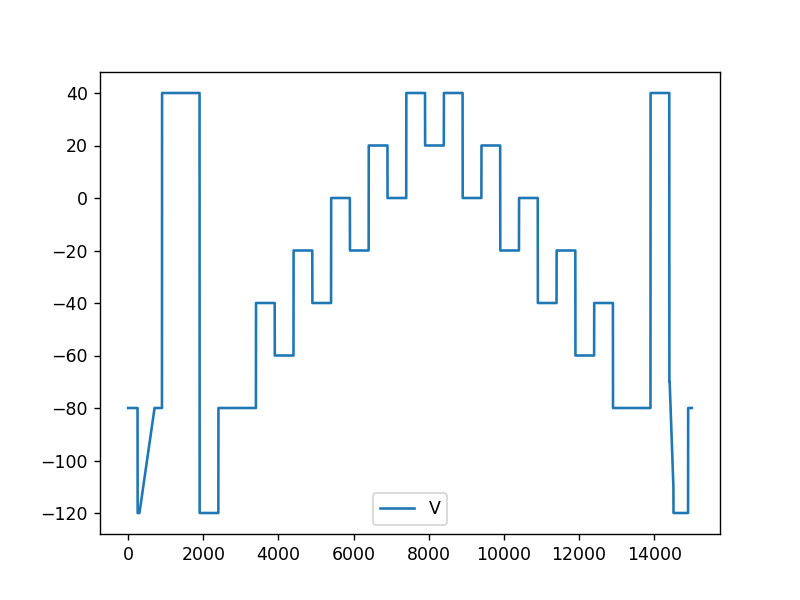

In [16]:
plt.figure()
plt.plot(ts, V(ts))
plt.legend('V')

<IPython.core.display.Javascript object>


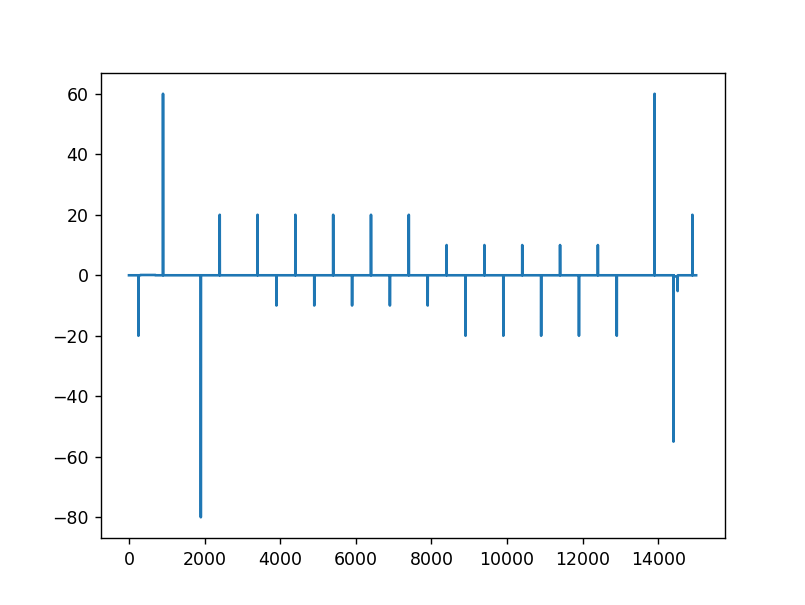

In [17]:
plt.figure()
plt.plot(ts, np.gradient(V(ts), ts))

## Testing casadi compat with V(t)

In [18]:
import pypei

In [47]:
import process_volts_again as pva
from importlib import reload

reload(pva)

<module 'process_volts_again' from 'C:\\Users\\dwu\\REPOS\\ionch\\process_volts_again.py'>

In [52]:
n_grid = 400

In [55]:
pf400 = pva.expanded_fn(n_grid)
def VX(t):
    return pf400(t/1000)

In [56]:
V = VX

In [ ]:
mdl_config = {
    'grid_size': n_grid,
    'basis_number': 40,
    'model': ion_model,
    'model_form': {
        'state': 2,
        'parameters': 9,
    },
    'time_span': tlim,
    'know_function': None,
    'dataset': None,
}

splmdl = pypei.modeller.Model(configuration=mdl_config)

In [58]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
###### idea: pre-discretise V(t) in the function (needs a new ion_model fn). Might work.